# 成交量指标策略
*市场短期是投票机，长期是称重机*

## 目录
1. 什么是成交量？
2. 如何计算成交量指标？
3. 如何用图形展示成交量？
4. 如何用成交量指标来编写策略？

## 什么是成交量？

成交量有三种可能，分别是量增、量减、量平。 

价格也有三种可能，分别是上涨、下跌、横盘。

量价理论表明价涨量增是上涨趋势的确认，反之价跌量增是下跌趋势的确认。

## 如何计算成交量指标？
---
### 1. ADV-平均成交量
$MA(volume,20)$

---

### 2. OBV
OBV属于市场的领先指标，计算方法是如果当天价格高于前一天的价格，当天成交量就用加的，反之就用减的来计算出OBV指标，这样有助于分析成交量与价格的关系。

---

### 3. A/D
A/D 指标在OBV的基础上对价格的波幅进行了计算，真实波幅越大，指标中的成交量占比越大。

$\frac{A}{D}=\frac{Close-Open}{High-Low}*Volume$

---

### 4. WVAP
按成交量来衡量价格的权重，成交量越大价格权重越大。

$sum(close * volume, 20)/sum(volume, 20)$

## 如何用图形展示成交量？

In [1]:
from jaqs_fxdayu.data import DataView
from jaqs_fxdayu.data import RemoteDataService
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\importlib\__init__.py:126: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _bootstrap._gcd_import(name[level:], package, level)


Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df

close = change_index(dv.get_ts('close_adj').loc[20170105:])
volume = change_index(dv.get_ts('volume').loc[20170105:])

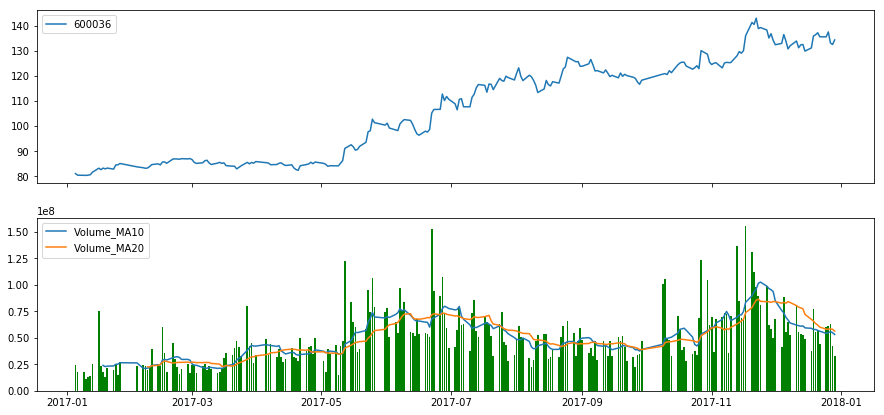

In [3]:
adv10 = ta.abstract.MA(volume, 10, price='600036.SH')
adv20 = ta.abstract.MA(volume, 20, price='600036.SH')

fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,7))
ax.plot(close['600036.SH'], label='600036')
ax.legend(loc='upper left')
ax1.bar(volume.index, volume['600036.SH'],color='g')
ax1.plot(adv10, label='Volume_MA10')
ax1.plot(adv20, label='Volume_MA20')
plt.legend(loc='upper left')
plt.show()

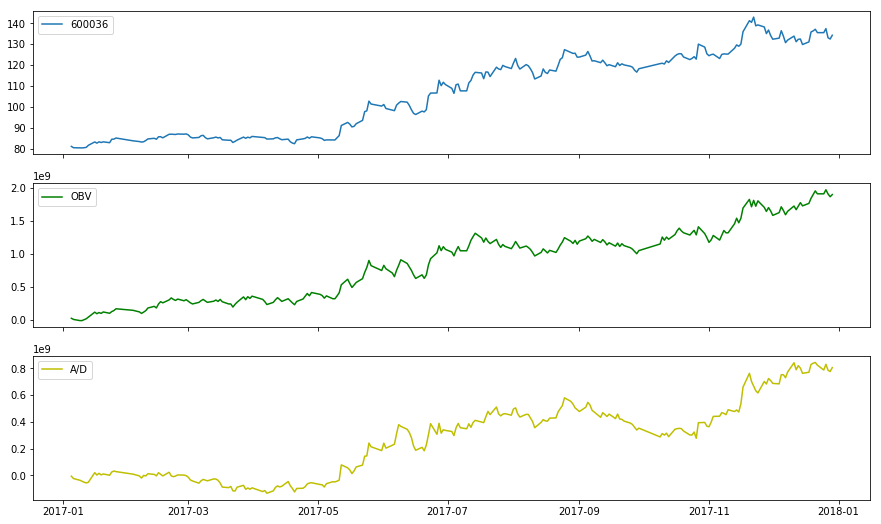

In [4]:
#OBV & A/D
Close = close['600036.SH'].values
Volume = volume['600036.SH'].values
Low = change_index(dv.get_ts('low_adj').loc[20170105:])['600036.SH'].values
High = change_index(dv.get_ts('high_adj').loc[20170105:])['600036.SH'].values


OBV = pd.Series(ta.OBV(Close, Volume), index=close.index)
AD = pd.Series(ta.AD(High, Low, Close, Volume), index=close.index)

fig, (ax, ax1,ax2) = plt.subplots(3, 1, sharex=True, figsize=(15,9))
ax.plot(close['600036.SH'], label='600036')
ax.legend(loc='upper left')
ax1.plot(OBV,'g', label='OBV')
ax1.legend(loc='upper left')
ax2.plot(AD, 'y', label='A/D')
ax2.legend(loc='upper left')
plt.show()

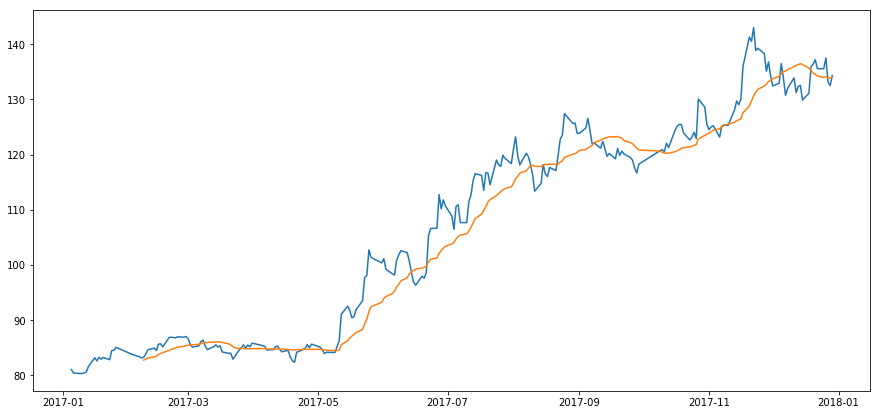

In [5]:
def ts_sum(ts, window=20):
    return ts.rolling(window).sum()

VWAP = ts_sum(pd.Series(Volume,index=volume.index)*close['600036.SH'])/ts_sum(pd.Series(Volume,index=volume.index))

plt.figure(figsize=(15,7))
plt.plot(close['600036.SH'])
plt.plot(VWAP)
plt.show()

## 如何用成交量指标来编写策略？
### VWAP策略
买入：

close>VWAP

卖出：

close<VWAP


In [1]:
#VWAP

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import (CtaTemplate,
                                                     ArrayManager)
import talib as ta


########################################################################
class VWAPStrategy(CtaTemplate):
    className = 'VWAPStrategy'
    author = 'xingetouzi'


    # 策略参数
    VWAPPeriod = 70
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    VWAPsignal = {}  
    transactionPrice = {}

    # 参数列表，保存了参数的名称
    paramList = ['className',
                 'author',
                 'symbolList',
                 'VWAPPeriod',
                 'lots',
                 'stopRatio']

    # 变量列表，保存了变量的名称
    varList = ['transactionPrice',
               'VWAPsignal']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super(VWAPStrategy, self).__init__(ctaEngine, setting)

    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.setArrayManagerSize(self.VWAPPeriod * 4)
        self.VWAPsignal = {s: 0 for s in self.symbolList}
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.putEvent()  # putEvent 能刷新策略UI界面的信息

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.putEvent()
        '''
        实盘在点击启动策略时, 此时的引擎下单逻辑改为True, 此时开始推送到onbar的数据, 会触发下单。
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """恢复策略（必须由用户继承实现）"""
        # 策略恢复会自动读取 varList 和 syncList 的数据，还原之前运行时的状态。
        # 需要注意的是，使用恢复，策略不会运行 onInit 和 onStart 的代码，直接进入行情接收阶段
        self.putEvent()

    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        # 在每个Tick推送过来的时候,进行updateTick,生成分钟线后推送到onBar.
        # 需要注意的是，如果没有updateTick，实盘将不会推送1分钟K线
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        self.writeCtaLog(u'%s, bar.close%s, %s' % (symbol, bar.close, bar.datetime))  # 可以将实盘的运行情况记录到日志里

        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)):
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)):
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

        self.putEvent()  # 每分钟更新一次UI界面

    def on3MinBar(self, bar):
        """3分钟K线推送"""
        symbol = bar.vtSymbol

        am3 = self.getArrayManager(symbol, "3m")

        if not am3.inited:
            return

        VWAP = ta.SUM(am3.close*am3.volume, self.VWAPPeriod) / ta.SUM(am3.volume, self.VWAPPeriod)

        if bar.close > VWAP[-1]:
            self.VWAPsignal[symbol] = -1
        elif bar.close < VWAP[-1]:
            self.VWAPsignal[symbol] = 1
        else:
            self.VWAPsignal[symbol] = 0

        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            if self.VWAPsignal[symbol] == 1:
                self.buy(symbol, bar.close * 1.02, self.lots)
            if self.VWAPsignal[symbol] == -1:
                self.short(symbol, bar.close * 0.98, self.lots)

    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function VWAPStrategy.onBar at 0x000001DB78224E18>, <__main__.VWAPStrategy object at 0x000001DB6B24D4A8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_3Min_bar函数functools.partial(<function VWAPStrategy.on3MinBar at 0x000001DB78224EA0>, <__main__.VWAPStrategy object at 0x000001DB6B24D4A8>)
2018-11-24 13:16:53.836400	开始回测
2018-11-24 13:16:53.836400	策略初始化
2018-11-24 13:16:53.838400	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-24 13:17:26.144651	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 13:17:26.172513	载入完成，数据量：12000
2018-11-24 13:17:26.175512	策略初始化完成
2018-11-24 13:17:26.176512	策略启动完成
2018-11-24 13:17:26.177511	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-24 13:17:26.190503	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-24 13:18:04.753330	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 13:18:04.816290	载入完成，数据量：42270
2018-11-24 13:18:04.817286	当前回放数据:[2018

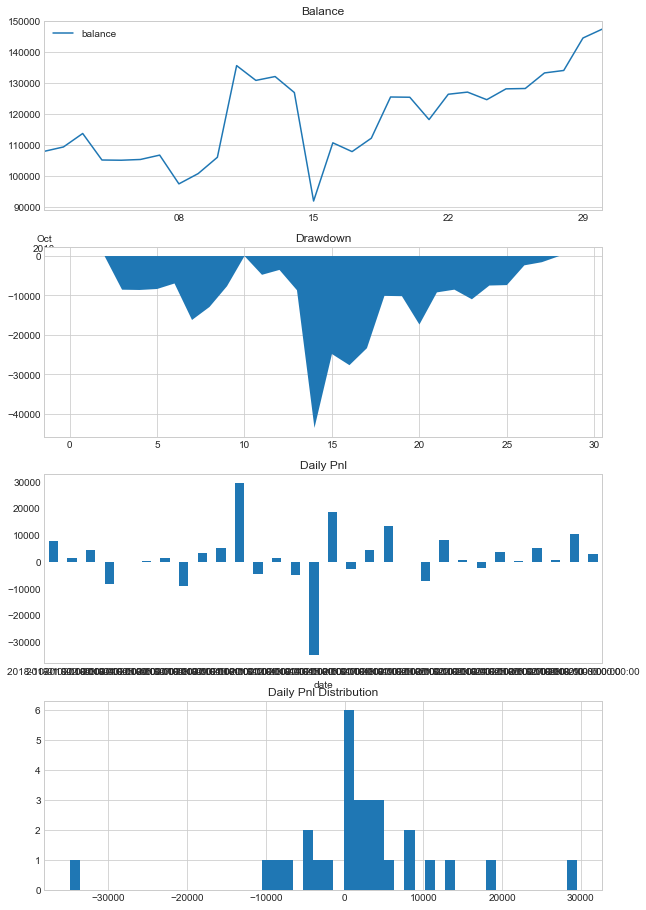

2018-11-24 13:19:19.202649	计算回测结果
2018-11-24 13:19:19.210646	交割单已生成
2018-11-24 13:19:19.210646	------------------------------
2018-11-24 13:19:19.210646	第一笔交易：	2018-10-15 14:46:00
2018-11-24 13:19:19.210646	最后一笔交易：	2018-10-30 23:58:00
2018-11-24 13:19:19.210646	总交易次数：	2
2018-11-24 13:19:19.210646	总盈亏：	46,909.45
2018-11-24 13:19:19.210646	最大回撤: 	-60,459.12
2018-11-24 13:19:19.210646	平均每笔盈利：	23,454.73
2018-11-24 13:19:19.211644	平均每笔滑点：	0.0
2018-11-24 13:19:19.211644	平均每笔佣金：	692.27
2018-11-24 13:19:19.211644	胜率		50.0%
2018-11-24 13:19:19.211644	盈利交易平均值	107,368.57
2018-11-24 13:19:19.211644	亏损交易平均值	-60,459.12
2018-11-24 13:19:19.211644	盈亏比：	1.78
2018-11-24 13:19:19.532460	交易记录没有达到10笔！
2018-11-24 13:19:19.532460	计算按日统计结果


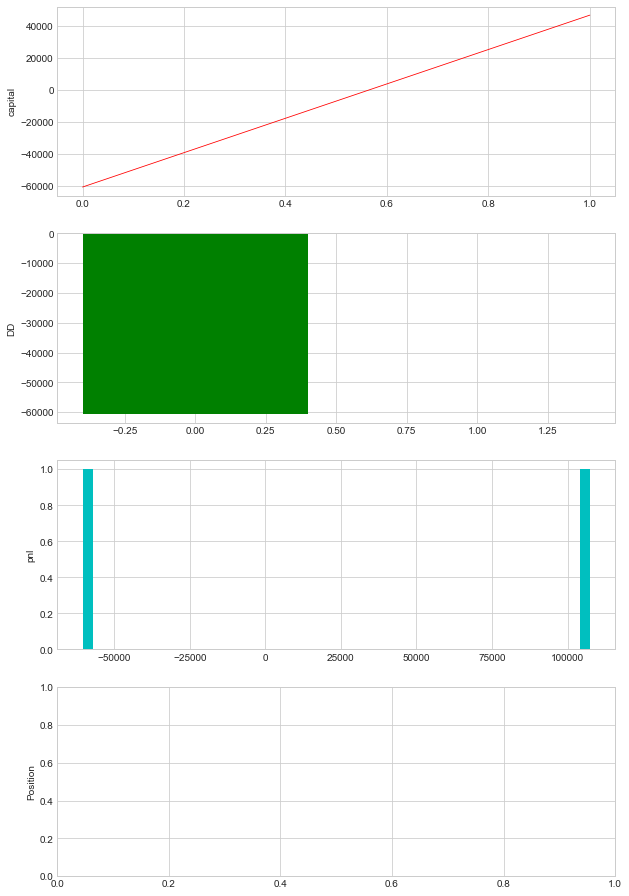

In [2]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(VWAPStrategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            # 'ETHUSDT:binance'
#                                                             'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('VWAPStrategyReport.xlsx')

## 作业
参考以上代码用其他成交量指标做策略